In [254]:
%pylab inline
import numpy as np
import math
from tqdm import trange
import code

Populating the interactive namespace from numpy and matplotlib


In [117]:
import gzip
import numpy as np
import os
import pathlib

# modified from https://github.com/geohot/tinygrad/blob/master/datasets/__init__.py
def load_mnist():
    parse = lambda file: np.frombuffer(gzip.open(file).read(), dtype=np.uint8).copy()
    mnist_dir = pathlib.Path('.').resolve() / 'data'
    X_train = (
        parse(mnist_dir / "train-images-idx3-ubyte.gz")[0x10:]
        .reshape((-1, 28 * 28))
        .astype(np.float32)
    )
    Y_train = parse(mnist_dir / "train-labels-idx1-ubyte.gz")[8:]
    X_test = (
        parse(mnist_dir / "t10k-images-idx3-ubyte.gz")[0x10:]
        .reshape((-1, 28 * 28))
        .astype(np.float32)
    )
    Y_test = parse(mnist_dir / "t10k-labels-idx1-ubyte.gz")[8:]
    return X_train, Y_train, X_test, Y_test

def encode_label(label: int):
    return np.array([1 if n == label else 0 for n in range(10)])

In [118]:
X_train, Y_train, X_test, Y_test = load_mnist()  
# one hot encoding
Y_train = np.array([encode_label(y) for y in Y_train])

In [290]:
def xavier_initialization(fan_in, fan_out):
    scalar = math.sqrt(1.)
    ret = np.random.uniform(low=-scalar, high=scalar, size=(fan_in,fan_out)) / np.sqrt(fan_in*fan_out)
    return ret.astype(np.float32)



In [192]:

def softmax_stable(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)
    #return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=0))

def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

def forward(input_vec,layer_1,layer_2):
    # forward pass of a single sample (1x784) array
    l1_out = input_vec.dot(layer_1)
    tanh_1 = np.tanh(l1_out)
    l2_out = tanh_1.dot(layer_2)
    out_vec = softmax_stable(l2_out)
    return out_vec
    
def cross_entropy_loss(predicted_vec, expected_vec):
    return -1*(expected_vec * np.log(predicted_vec)).sum(axis=1)
    
def d_tanh(x):
    return 1 - (x**2)
    
def sigmoid(x):
    return 1/(np.exp(-x)+1)    

def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)

def relu(x):
    return np.maximum(x,0)

def d_relu(x):
    return (x > 0).astype(float32)


In [282]:
# code.interact(local=locas())
def shitty_conv2d(input_vec, conv_layer, stride:int , zero_padding: int):
    # input_vec: (width x height x depth)
    # conv_layer: (width x height x depth x num_filters)
    # stride: int
    # zero_padding: int
    #
    # out: (w x h x num_filters)
    width,height,_ = input_vec.shape
    filter_size,_,_,num_filters = conv_layer.shape
    w = width if zero_padding else width - 2*zero_padding
    h = height if zero_padding else height - 2*zero_padding
    
    r = (filter_size - 1) // 2
    padded_input = np.pad(input_vec, r, mode='constant')
    
    out = np.zeros(w,h,num_filters)
    
    for num_filt in range(num_filters):
        for i in range(w):
            for j in range(h):
                out[i,j,num_filt] = np.sum(padded_input[(i-r):(i+r),(j-r):(j+r),:]*conv_layer[i,j,:,num_filt])
    
    return out


def get_gradient(x_batch, y_batch, layer_1, layer_2, conv=False):
    l1_out = x_batch.dot(layer_1)
    tanh_1 = np.tanh(l1_out)
    l2_out = tanh_1.dot(layer_2)
    out = softmax_stable(l2_out)
    loss=cross_entropy_loss(out,y_batch).mean()

    d_loss = (out - y_batch) / (y_batch.shape[0]) 
    
    d_out_vec = d_softmax(d_loss)*d_loss 

    d_l2 = (tanh_1.T.dot(d_out_vec))

    d_tanh = d_out_vec.dot(layer_2.T)
    dx_l1_out = (1-tanh_1**2) * d_tanh

    d_l1_out = x_batch.T.dot(dx_l1_out)
    return loss,d_l1_out,d_l2,out


In [246]:

def train(X_train, Y_train, layer_1, layer_2, BATCH_SIZE=64, epochs=100, lr=0.001, mu=0.90):
    losses = []
    accuracies = []
    v1 =0
    v2 =0
    for i in (t := trange(epochs)):
        batch_indices = np.random.randint(0,X_train.shape[0], size=(BATCH_SIZE))

        loss, d_l1, d_l2, out = get_gradient(X_train[batch_indices],Y_train[batch_indices],layer_1,layer_2)
        
        test_maxes = np.argmax(out,axis=1)
        label_maxes = np.argmax(Y_train[batch_indices],axis=1)
        accuracy = (test_maxes == label_maxes).mean()
        
        v1 = mu * v1 - lr * d_l1
        v2 = mu * v2 - lr * d_l2
        layer_1 = layer_1 + v1
        layer_2 = layer_2 + v2 
#         layer_1 = layer_1 - lr*d_l1
#         layer_2 = layer_2 - lr*d_l2

        t.set_description(f'loss: {loss}, accuracy: {accuracy*100}%')
        losses.append(loss)
        accuracies.append(accuracy)
    return layer_1,layer_2,losses,accuracies

loss: 3.898968715808485, accuracy: 90.625%: 100%|███████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.29it/s]


7 7


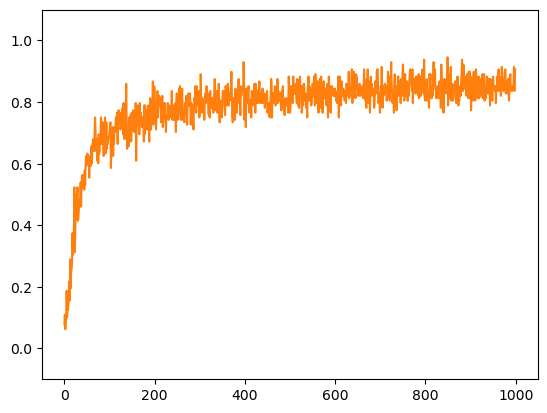

In [291]:
BATCH_SIZE = 128
layer_1 = xavier_initialization(784,128)
layer_2 = xavier_initialization(128,10)

layer_1,layer_2,losses,accuracies = train(X_train,Y_train,layer_1,layer_2,BATCH_SIZE,1000)

test1 = forward(X_test[0],layer_1,layer_2)
print(np.argmax(test1), Y_test[0])

#imshow(X_test[0].reshape(28,28))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [292]:
test_predictions = np.argmax(forward(X_test,layer_1,layer_2),axis=1)
acc = (test_predictions == Y_test).mean()
print(acc)

0.8631


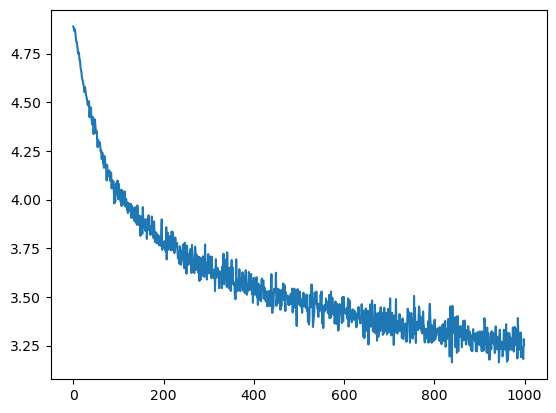

In [249]:
plot(losses)

array([[[6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6]],

       [[6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6]],

       [[6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6],
        [6, 6, 6, 6, 6]]])

array([], dtype=int64)